<a href="https://colab.research.google.com/github/geoffwoollard/compSPI/blob/gw/notebooks/uniform_rotations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal: visualize distribution of rotations on sphere

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [46]:
!wget https://raw.githubusercontent.com/geoffwoollard/compSPI/1386d017ed3e09fff7955838660ad2e6f0805105/src/coords.py
import coords

# Skopi
* skopi has some code for visualizing rotations, as well as its own way of generating random points on the sphere
* https://github.com/chuckie82/skopi/blob/9cfbd849bb8ae05ef9ae69cf630f6bef99e0cbc1/skopi/geometry/generate.py

In [3]:
def _volume_Nball(n):
    """Volume of a unitary N-Ball."""
    if n == 0:
        return 1
    return _surface_Nsphere(n-1) / n

def _surface_Nsphere(n):
    """Surface of a unitary N-Sphere."""
    if n == 0:
        return 2
    return 2 * np.pi * _volume_Nball(n-1)

def _point_on_Nsphere_loop(points, delta, currDim, NDim, ind,
                           base=1, last=1, half=False):
    """Internal and recursive logic of points_on_Nsphere."""
    delta_w = delta / last
    w = 0.5 * delta_w

    if currDim+2 == NDim:
        w_limit = np.pi if half else 2*np.pi
        while w < w_limit - delta_w/2:
            points[ind, currDim] = base * np.cos(w)
            points[ind, currDim+1] = base * np.sin(w)
            ind += 1
            w += delta_w
    else:
        while w < np.pi - delta_w/2:
            old_ind = ind
            ind = _point_on_Nsphere_loop(points, delta_w, currDim+1, NDim,
                                         ind, base*np.sin(w), np.sin(w), half)
            points[old_ind:ind, currDim] = base * np.cos(w)
            w += delta_w
    return ind

def points_on_Nsphere(num_pts, N, half=False):
    """
    Attempt to distribute points evenly on a unit N-sphere.
    This N-sphere corresponds to the set of points in an N+1 dimensional
    Euclidean space that are at a unit distance of the origin.
    :param num_pts: Number of points
    :param half: Bool. If True, distribute on half the N-sphere.
    :return: List of (N+1)-D points [num_pts, N+1]
    """
    dim_num = N+1

    surface_area = _surface_Nsphere(N)
    if half:
        surface_area /= 2
    delta = np.exp(np.log(surface_area / num_pts) / N)
    iteration = 0
    ind = 0
    max_iter = 1000

    points = np.zeros((2 * num_pts, dim_num))
    best_pts = None
    best_num_points = 2 * num_pts

    while ind != num_pts and iteration < max_iter:
        ind = _point_on_Nsphere_loop(
            points, delta, 0, dim_num, 0, half=half)
        delta *= np.exp(np.log(float(ind) / num_pts) / N)
        iteration += 1

        if num_pts <= ind < best_num_points:
            best_pts = points[:ind].copy()
            best_num_points = ind

    return best_pts[:num_pts]

def points_on_Nsphere(num_pts, N, half=False):
    """
    Attempt to distribute points evenly on a unit N-sphere.
    This N-sphere corresponds to the set of points in an N+1 dimensional
    Euclidean space that are at a unit distance of the origin.
    :param num_pts: Number of points
    :param half: Bool. If True, distribute on half the N-sphere.
    :return: List of (N+1)-D points [num_pts, N+1]
    """
    dim_num = N+1

    surface_area = _surface_Nsphere(N)
    if half:
        surface_area /= 2
    delta = np.exp(np.log(surface_area / num_pts) / N)
    iteration = 0
    ind = 0
    max_iter = 1000

    points = np.zeros((2 * num_pts, dim_num))
    best_pts = None
    best_num_points = 2 * num_pts

    while ind != num_pts and iteration < max_iter:
        ind = _point_on_Nsphere_loop(
            points, delta, 0, dim_num, 0, half=half)
        delta *= np.exp(np.log(float(ind) / num_pts) / N)
        iteration += 1

        if num_pts <= ind < best_num_points:
            best_pts = points[:ind].copy()
            best_num_points = ind

    return best_pts[:num_pts]

def get_uniform_quat(num_pts, avoid_symmetric=False):
    """
    Get num_pts of unit quaternions evenly distributed on the 3-sphere.
    :param num_pts: The number of quaternions to return
    :param avoid_symmetric:
        If specified, count opposite quaternions as identical.
    :return: Quaternion list of shape [number of quaternion, 4]
    """
    return points_on_Nsphere(num_pts, 3, half=avoid_symmetric)

In [4]:
def visualize_quaternions(quaternions):
    """
    Visualize how given quaternions rotate the [0,0,1] unit vector on the surface
    of the unit sphere.
    
    :param quaternions: array of quaternions
    """
    from matplotlib import pyplot as plt
    
    # apply quaternions to [0,0,1] and convert to Cartesian coordinates
    coords = np.zeros((quaternions.shape[0], 3))
    for i in range(coords.shape[0]):
        theta, axis = quaternion_to_angle_axis(quaternions[i])
        R = angle_axis_to_rot3d(axis, theta)
        coords[i] = R.dot(np.array([0,0,1]))
    
    # generate latitutde/longitude lines along unit sphere
    phi = np.linspace(0, np.pi, 20)
    theta = np.linspace(0, 2 * np.pi, 40)
    x = np.outer(np.sin(theta), np.cos(phi))
    y = np.outer(np.sin(theta), np.sin(phi))
    z = np.outer(np.cos(theta), np.ones_like(phi))

    # plot coordinates and unit sphere mesh
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d'})
    ax.plot_wireframe(x, y, z, color='k', rstride=1, cstride=1, alpha=0.2)
    ax.scatter(coords[:,0], coords[:,1], coords[:,2], s=10, c='r', zorder=10)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    
    plt.tight_layout()
    plt.show()
    
    return

def quaternion_to_angle_axis(quaternion):
    """
    Convert quaternion to a right hand rotation theta about certain axis.
    :param quaternion:
    :return:  angle, axis
    """
    ha = np.arccos(quaternion[0])
    theta = 2 * ha
    if theta < np.finfo(float).eps:
        theta = 0
        axis = np.array([1, 0, 0])
    else:
        axis = quaternion[[1, 2, 3]] / np.sin(ha)
    return theta, axis

def angle_axis_to_rot3d(axis, theta):
    """
    Convert rotation with angle theta around a certain axis to a rotation matrix in 3D.
    :param axis: A numpy array for the rotation axis.
        Axis names 'x', 'y', and 'z' are also accepted.
    :param theta: Rotation angle.
    :return:
    """

    axis = axis.astype(float)
    axis /= np.linalg.norm(axis)
    a = axis[0]
    b = axis[1]
    c = axis[2]
    cos_theta = np.cos(theta)
    bracket = 1 - cos_theta
    a_bracket = a * bracket
    b_bracket = b * bracket
    c_bracket = c * bracket
    sin_theta = np.sin(theta)
    a_sin_theta = a * sin_theta
    b_sin_theta = b * sin_theta
    c_sin_theta = c * sin_theta
    rot3d = np.array(
        [[a * a_bracket + cos_theta, a * b_bracket - c_sin_theta, a * c_bracket + b_sin_theta],
         [b * a_bracket + c_sin_theta, b * b_bracket + cos_theta, b * c_bracket - a_sin_theta],
         [c * a_bracket - b_sin_theta, c * b_bracket + a_sin_theta, c * c_bracket + cos_theta]])
    return rot3d

  

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


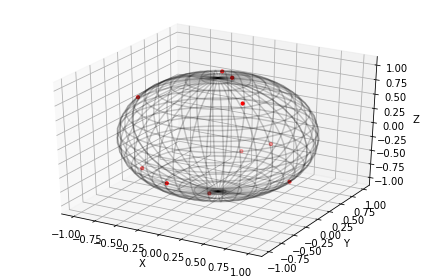

In [ ]:
qs = get_uniform_quat(10)
visualize_quaternions(qs)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


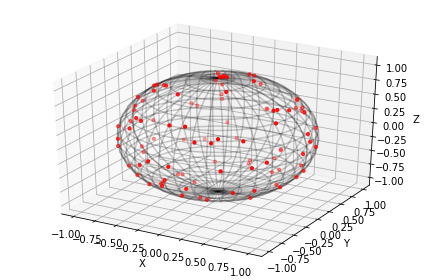

In [ ]:
qs = get_uniform_quat(100)
visualize_quaternions(qs)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


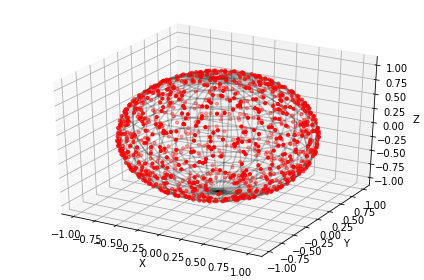

In [5]:
qs = get_uniform_quat(1000)
visualize_quaternions(qs)

Rotations
Should be non uniform

In [56]:
def generate_rotations_random_euler(n_rotations):
  Rs = np.zeros((n_rotations,3,3))
  idx = 0
  for phi, theta, psi in np.random.uniform(low=0,high=2*np.pi,size=3*n_rotations).reshape(n_rotations,3):
    Rs[idx] = coords.EA_to_R3(phi, theta, psi)
    idx += 1
  return(Rs)

def visualize_rotations(rotations):
    """
    Visualize how given quaternions rotate the [0,0,1] unit vector on the surface
    of the unit sphere.
    
    :param rotations: array of rotations
    """
    from matplotlib import pyplot as plt
    
    # apply quaternions to [0,0,1] and convert to Cartesian coordinates
    coords = np.zeros((rotations.shape[0],3))
    for i in range(coords.shape[0]):
      coords[i] = rotations[i].dot(np.array([0,0,1]))
    
    # generate latitutde/longitude lines along unit sphere
    phi = np.linspace(0, np.pi, 20)
    theta = np.linspace(0, 2 * np.pi, 40)
    x = np.outer(np.sin(theta), np.cos(phi))
    y = np.outer(np.sin(theta), np.sin(phi))
    z = np.outer(np.cos(theta), np.ones_like(phi))

    # plot coordinates and unit sphere mesh
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d'})
    ax.plot_wireframe(x, y, z, color='k', rstride=1, cstride=1, alpha=0.2)
    ax.scatter(coords[:,0], coords[:,1], coords[:,2], s=10, c='r', zorder=10)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    
    #plt.tight_layout()
    #plt.show()
    
    return coords, ax




/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


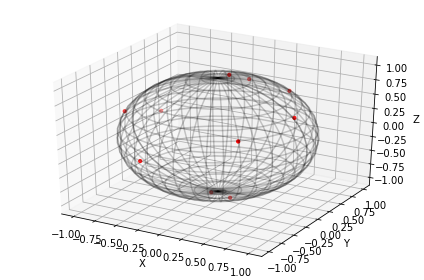

In [ ]:
Rs = generate_rotations_random_euler(10)
visualize_rotations(Rs)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


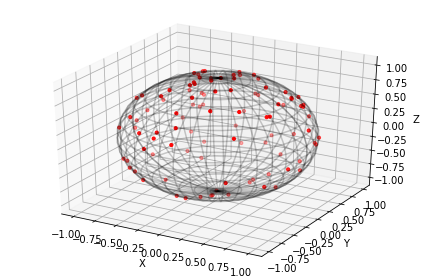

In [ ]:
Rs = generate_rotations_random_euler(100)
visualize_rotations(Rs)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


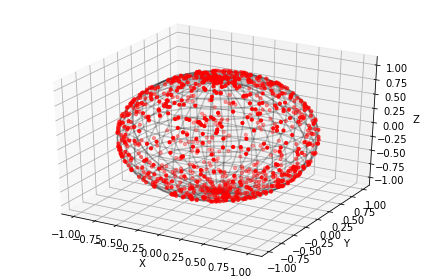

In [8]:
Rs = generate_rotations_random_euler(1000)
visualize_rotations(Rs)

Notice how the points are bunching at the poles

# random quaternions: $U[0,1)2\pi$  vs $U[0,1)\pi/2 $

* see very simple code for uniform quaternions in Youssef's https://github.com/ynashed/CryoNet/blob/develop/src/geom_utils.py#L309
  * note the difference in the angle to algorithm 2 in https://www.ri.cmu.edu/pub_files/pub4/kuffner_james_2004_1/kuffner_james_2004_1.pdf


In [79]:
def get_random_quat(num_pts,method = 'sphere'):
    """
    Get num_pts of unit quaternions with a uniform random distribution.
    :param num_pts: The number of quaternions to return
    : param method: 
      hemisphere: uniform on the 4 hemisphere, with x in [0,1], y,z in [-1,1]
      sphere: uniform on the sphere, with x,y,z in [-1,1]
    :return: Quaternion list of shape [number of quaternion, 4]
    """
    u = np.random.rand(3, num_pts)
    u1, u2, u3 = [u[x] for x in range(3)]

    quat = np.zeros((4, num_pts))
    if method == 'hemisphere':
      angle = np.pi / 2
    elif method == 'sphere':
      angle = 2 * np.pi
    else:
      assert False, 'use hemisphere or sphere'
    
    quat[0] = np.sqrt(1 - u1) * np.sin(angle * u2)
    quat[1] = np.sqrt(1 - u1) * np.cos(angle * u2)
    quat[2] = np.sqrt(u1) * np.sin(angle * u3)
    quat[3] = np.sqrt(u1) * np.cos(angle * u3)

    return np.transpose(quat)



/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


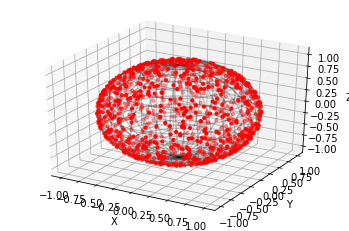

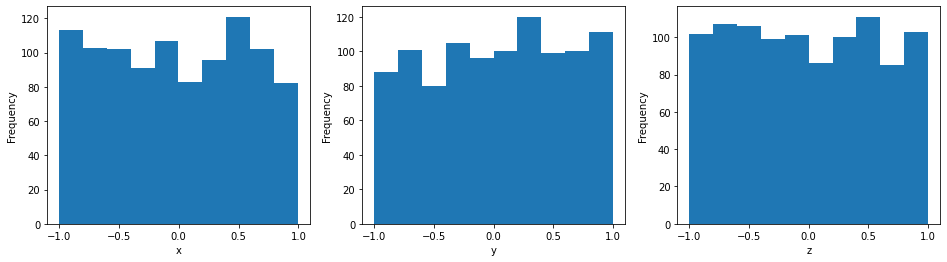

In [80]:
num_pts=1000
qs = get_random_quat(num_pts, 'sphere')

Rs = np.empty((num_pts,3,3))
for idx in range(num_pts):
  Rs[idx] = coords.quaternion_to_R(qs[idx])

xyz, ax = visualize_rotations(Rs)

fig, axes = plt.subplots(ncols=3, figsize=(16,4))
labels = ['x','y','z']
for idx in range(3):
  pd.Series(xyz[:,idx]).plot.hist(ax=axes[idx])
  axes[idx].set_xlabel(labels[idx])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


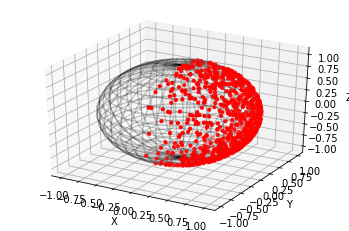

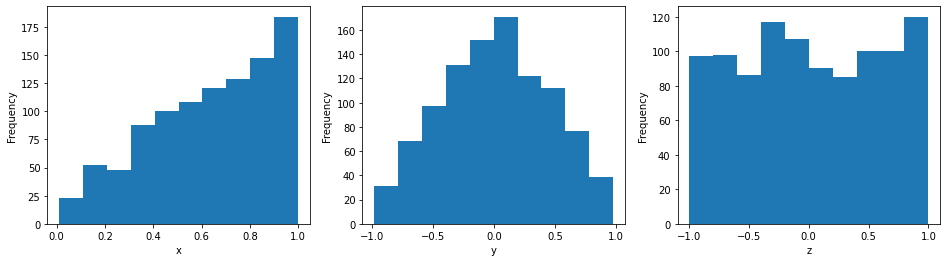

In [81]:
num_pts=1000
qs = get_random_quat(num_pts, 'hemisphere')

Rs = np.empty((num_pts,3,3))
for idx in range(num_pts):
  Rs[idx] = coords.quaternion_to_R(qs[idx])

xyz, ax = visualize_rotations(Rs)

fig, axes = plt.subplots(ncols=3, figsize=(16,4))
labels = ['x','y','z']
for idx in range(3):
  pd.Series(xyz[:,idx]).plot.hist(ax=axes[idx])
  axes[idx].set_xlabel(labels[idx])